<a href="https://colab.research.google.com/github/vmavis/colab/blob/main/llm_using_roberta.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Importing Data and Libraries**

External libraries like simpletranformers require us to install them first every time we run the code.

In [ ]:
!pip install simpletransformers

All the necessary libraries and functions are installed and imported first. Further need of other libraries and functions may require us to import them seperately.

Numpy lets us work with arrays while pandas let us work with dataframes and read our data. Seaborn and matplotplib let us create visualisations. Re and spacy let us work with data cleansing. Sklearn has a number of forks that let us split our data into training and testing sets, transform our data into vectors, create classification models, and print metrics to measure goodness of our models. Simpletransformers let us create LLM models.

In [ ]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import re
import spacy
from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

from simpletransformers.classification import ClassificationModel

The data set is read into a data frame and read_csv indicates that Python is attempting to read a csv (Comma Seperated Value) file. A glimpse of the data is shown using head(). If the number of rows is not specified, the first five rows will automatically be printed.

In [ ]:
no1 = pd.read_csv('/content/data_1D.csv')
no1.head()

,Unnamed: 0,text,label
0,0,Tamron AF 70-300mm F/4.0-5.6 Di LD Macro Telep...,Electronics
1,1,Softline Butterfly Women's Cotton Camisole,Clothing & Accessories
2,2,Indian Economy: For UPSC Civil Services & Othe...,Books
3,3,Fujifilm X-T3 Mirrorless Digital Camera with X...,Electronics
4,4,"Barata Formal Ties For Men, Navy Blue Tie Form...",Clothing & Accessories


## **Data Analysis**

 We check the number of rows and columns using shape. We then check the number of null values and the data type of each variable using info.

In [ ]:
no1.shape

(12606, 3)

In [ ]:
no1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12606 entries, 0 to 12605
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  12606 non-null  int64 
 1   text        12606 non-null  object
 2   label       12606 non-null  object
dtypes: int64(1), object(2)
memory usage: 295.6+ KB


We check the number of articles under each label. The label with the highest number of articles is household, while the lable with the lowerst number of articles is clothing & accessories.

In [ ]:
no1.groupby('label').size()

label
Books                     2962
Clothing & Accessories    2190
Electronics               2615
Household                 4839
dtype: int64

For visualisation purposes, we can turn the dataframe into a count plot.

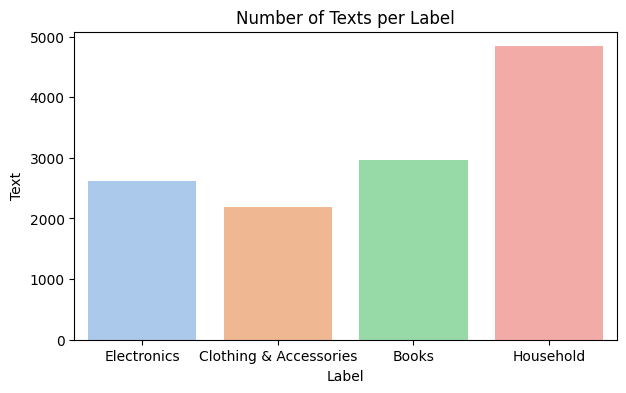

In [ ]:
plt.figure(figsize=(7,4))
sns.countplot(data=no1, x='label', palette='pastel').set(title='Number of Texts per Label', xlabel='Label', ylabel='Text')
plt.show()

## **Data Preprocessing**

As we have a large amount of data, a total of 5,000 samples are taken to be used in this code.

In [ ]:
no1 = no1.sample(5000)

A function to cleanse our data is defined below. All letters are first converted into lowercase. Certain patterns are then either removed or replaced with a white space. The mentioned patterns are:

- re.sub(r'\d+', '', i ): removing one or more digit characters
- re.sub(r'[^\w]', ' ', i): replacing alpha-numeric characters at the beginning of the string with a white space
- re.sub(r'https', '', i): removing https
- re.sub(r'com', '', i): removing com
- re.sub(r'((?<=^)|(?<= )).((?=$)|(?= ))', '', i): removing single character words
- re.sub(r'\s+', ' ', i): replacing one or more white spaces with a single white space

- re.sub(r'\s$', '', i): removing a white space at the end of the string

In [ ]:
def cleansing(df):
    df_clean = df.str.lower()
    df_clean = [re.sub(r'\d+', '', i ) for i in df_clean]
    df_clean = [re.sub(r'[^\w]', ' ', i) for i in df_clean]
    df_clean = [re.sub(r'https', '', i) for i in df_clean]
    df_clean = [re.sub(r'com', '', i) for i in df_clean]
    df_clean = [re.sub(r'((?<=^)|(?<= )).((?=$)|(?= ))', '', i) for i in df_clean]
    df_clean = [re.sub(r'\s+', ' ', i) for i in df_clean]
    df_clean = [re.sub(r'\s$', '', i) for i in df_clean]
    return df_clean

Only the column 'Text' is involved in the cleansing process. A glimpse of the clean text is shown below.

In [ ]:
no1['clean_text'] = cleansing(no1['text'])
no1['clean_text'].head()

11968    tech marketing men cotton lungi multi coloured...
6388     philips series ac air purifier white style ac ...
6476     qube by fort collins women sweatshirt qube by ...
11065    dharam paul traders manual stainless steel pur...
4173     prestige pgmfb watt grill sandwich toaster wit...
Name: clean_text, dtype: object

All English stop words are loaded from the spacy library. Words of the clean text that match those stop words are removed.

In [ ]:
nlp = spacy.load("en_core_web_sm")
no1['clean_text'] = no1['clean_text'].apply(lambda x: ' '.join([word for word in x.split() if nlp.vocab[word].is_stop==False]))
no1['clean_text'].head()

11968    tech marketing men cotton lungi multi coloured...
6388     philips series ac air purifier white style ac ...
6476     qube fort collins women sweatshirt qube fort c...
11065    dharam paul traders manual stainless steel pur...
4173     prestige pgmfb watt grill sandwich toaster fix...
Name: clean_text, dtype: object

The clean text is set as our x variable and the labels are set as our y variable. The data is then split into two. 70% is allocated for the training set and the rest is allocated for the testing set.

In [ ]:
x = no1['clean_text']
y = no1['label']
xtrain, xtest, ytrain, ytest = train_test_split(x, y, train_size=0.7, random_state=42)

The numbers of rows and columns of each one are shown below. Each training set has 3,500 rows while each testing set has 1,500 rows. They only have 1 column as only 1 variable are assigned to both x and y.

In [ ]:
print(xtrain.shape, xtest.shape, ytrain.shape, ytest.shape)

(3500,) (1500,) (3500,) (1500,)


For the RoBERTa training and testing sets, each label is replaced with a number. The x and y of the newly replaced values are combined together into a dataframe. The training set has 3,500 rows and the testing set has 1,500 rows.

In [ ]:
rb_ytrain = ytrain.replace(['Books', 'Clothing & Accessories', 'Electronics', 'Household'], [0,1,2,3])
rb_ytest = ytest.replace(['Books', 'Clothing & Accessories', 'Electronics', 'Household'], [0,1,2,3])

In [ ]:
rbtrain = pd.concat([xtrain, rb_ytrain], axis=1)
rbtest = pd.concat([xtest, rb_ytest], axis=1)
print(rbtrain.shape, rbtest.shape)

(3500, 2) (1500, 2)


## **Vectorization**

Vectorization is converting input data from its raw format into numerical vectors. It is done to get some distinct features out of the text for the model to train on. There are many methods of vectorization. In this code, TF-IDF Vectorizer and Count Vectorizer are used to help us train our models.

### **TF-IDF Vectorizer**

TF-IDF (term frequency-inverse document frequency) is used to show how important a word is to a document in a collection or corpus. TF (term frequency) measures how often a term appears in a document. IDF (inverse document frequency) measures how important a term is across all documents in the corpus.

To see the importance of each term of our data, TfidfVectorizer is used. It converts a collection of raw documents to a matrix of TF-IDF features. The clean text is then fitted and transformed into numbers. The fit_transform function learns the vocabulary dictionary and returns term-document matrix. The transform function performs scaling of the data and returns the transformed array. The fit function is not used on the validation and test sets as it can introduce bias to those two sets.

In [ ]:
tfidfvec = TfidfVectorizer()
train_tfidf = tfidfvec.fit_transform(xtrain)
test_tfidf = tfidfvec.transform(xtest)

### **Count Vectorizer**

Count Vectorizer converts a collection of text documents into a matrix of token counts, which are vectors containing the frequency of each word that occurs in the entire text. Each unique word is represented by a column of the matrix and each text sample from the document is represented by a row in the matrix. The value of each cell is the count of the word in that particular text sample.

To determine the number of words we want to use in the vectorizer, we use ngram_range where the first parameter is the minimum and the second parameter is the maximum. Only individual words are considered if we set the ngram_range to 1,1. Just like the previous method, the clean text of the training set is fitted and transformed. The fit function is not used on the testing set as it can introduce bias.



In [ ]:
countvec = CountVectorizer(ngram_range=(1,1))
train_count = countvec.fit_transform(xtrain)
test_count = countvec.transform(xtest)

## **KNN Model**

The K-Nearest Neighbors (KNN) algorithm is a non-parametric supervised learning classifier which relies on distance to make classifications or predictions. KNN  determines the class of a data point by majority voting principle. If k is set to 4, the classes of 4 closest points are checked.

This algorithm does not make any assumptions and works well on data with multiple classes. It also only requires a small number of parameters which do not need to be specified most of the time. However, it is sensitive to outlier, prone to overfitting, and not time-efficient if there exists many data points.

In [ ]:
knn = KNeighborsClassifier(n_neighbors=4)

### **KNN with TFIDF Vectorizer**

We create a KNN model with data vectorized using TFIDF Vectorizer.

In [ ]:
knn.fit(train_tfidf, ytrain)
test_knn_tfidf = knn.predict(test_tfidf)

### **KNN with Count Vectorizer**

We create a KNN model with data vectorized using Count Vectorizer.

In [ ]:
knn.fit(train_count, ytrain)
test_knn_count = knn.predict(test_count)

## **Decision Tree Model**

The Decision Tree algorithm is also a non-parametric supervised learning classifier. It builds a tree where each internal node represents a test on an attribute, each branch represents an outcome of the test, and each leaf node represents a class label. It keeps on splitting the training data into subsets based on the values of the attributes until a stopping criterion is met, such as the maximum depth of the tree.

This algorithm handles missing values vey well. It is also very easy to understand even for beginners. However, it is prone to overfitting and can be expensive to train as it takes a greedy search approach.

In [ ]:
dt = DecisionTreeClassifier(max_depth=4)

### **Decision Tree with TFIDF Vectorizer**

We create a Decision Tree model with data vectorized using TFIDF Vectorizer.

In [ ]:
dt.fit(train_tfidf, ytrain)
test_dt_tfidf = dt.predict(test_tfidf)

### **Decision Tree with Count Vectorizer**

We create a Decision Tree model with data vectorized using Count Vectorizer.

In [ ]:
dt.fit(train_count, ytrain)
test_dt_count = dt.predict(test_count)

## **Model Comparison**

To see how well the models perform against the testing sets, we print the accuracy of each one. As the models using TF-IDF Vectorizer yield higher accuracies, we only print the classification reports those models. KNN with TFIDF Vectorizer has the highest accuracy of 93%.

In [ ]:
acc_knn_tfidf = accuracy_score(ytest, test_knn_tfidf)
acc_knn_count = accuracy_score(ytest, test_knn_count)
print(acc_knn_tfidf, acc_knn_count)

0.93 0.6626666666666666


In [ ]:
acc_dt_tfidf = accuracy_score(ytest, test_dt_tfidf)
acc_dt_count = accuracy_score(ytest, test_dt_count)
print(acc_dt_tfidf, acc_dt_count)

0.6453333333333333 0.6446666666666667


In [ ]:
print(classification_report(ytest, test_knn_tfidf))

                        precision    recall  f1-score   support

                 Books       0.94      0.94      0.94       339
Clothing & Accessories       0.92      0.97      0.94       284
           Electronics       0.88      0.93      0.91       308
             Household       0.96      0.90      0.93       569

              accuracy                           0.93      1500
             macro avg       0.92      0.94      0.93      1500
          weighted avg       0.93      0.93      0.93      1500



In [ ]:
print(classification_report(ytest, test_dt_tfidf))

                        precision    recall  f1-score   support

                 Books       0.97      0.47      0.64       339
Clothing & Accessories       0.93      0.62      0.74       284
           Electronics       0.94      0.24      0.39       308
             Household       0.52      0.98      0.68       569

              accuracy                           0.65      1500
             macro avg       0.84      0.58      0.61      1500
          weighted avg       0.79      0.65      0.62      1500



## **LLM and Hyperparameter Tuning**

RoBERTa, which stands for Robustly Optimized BERT Approach, is a BERT modification developed by researchers at Facebook AI. BERT itself stands for Bidirectional Encoder Representations from Transformers, which is a transformer method used to process input sequences and generate representations of words in a sentence using self-attention.

This method removes the NSP (next sentence prediction) objective, which allows for an improvement in downstream task performance. It is also trained over a longer period of time and with more data, which results in a higher accuracy and better results. However, it takes an incredibly long time to run, hence the small number of epochs set in this model. Longer time to run equals to larger carbon footprint.

The hyperparameters tuned in this model are the number of epochs and batch size. A low number of epochs results in a faster computation. A high number of batch size may result in better evaluation, while a low number of batch size sacrifices that for a faster computation. I find 16 to be the perfect size for training batches.

In [ ]:
rb = ClassificationModel("roberta", "roberta-base", num_labels=4, args={"num_train_epochs": 3, "train_batch_size": 16, "overwrite_output_dir": True},)
rb.train_model(rbtrain)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.out_proj.bias']
You should pr

  0%|          | 0/3500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 0 of 3:   0%|          | 0/219 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/219 [00:00<?, ?it/s]

Running Epoch 2 of 3:   0%|          | 0/219 [00:00<?, ?it/s]

(657, 0.26781223623629213)

To see how well the model performs against the testing set, we print the MCC (Matthews correlation coefficient) score and cross entropy loss. As it yields a very high MCC score and a very low cross entropy loss, we can conclude that this model performs extremely well.

In [ ]:
rb_result, rb_model_outputs, rb_wrong_predictions = rb.eval_model(rbtest)
print(rb_result)

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/1500 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/188 [00:00<?, ?it/s]

{'mcc': 0.9396155012503314, 'eval_loss': 0.19462441763979324}


In [ ]:
rb_x = xtest.tolist()
rb_predict_test, m = rb.predict(rb_x)
rb_predict_test

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

array([1, 1, 0, ..., 1, 3, 2])

The labels of the testing data are predicted using RoBERTa. The result is shown below.

In [ ]:
rbtest['predictions'] = rb_predict_test
rbtest['predictions'] = rbtest['predictions'].replace([0,1,2,3], ['Books', 'Clothing & Accessories', 'Electronics', 'Household'])
rbtest['predictions']

10772    Clothing & Accessories
8695     Clothing & Accessories
7721                      Books
11646                     Books
11384    Clothing & Accessories
                  ...          
4872                Electronics
7820                  Household
8653     Clothing & Accessories
7818                  Household
11805               Electronics
Name: predictions, Length: 1500, dtype: object

In [ ]:
rbtest.head()

,clean_text,label,predictions
10772,studio shringaar women polyester blouse beauti...,1,Clothing & Accessories
8695,isakaa baby cotton sleeve tshirts refresh babi...,1,Clothing & Accessories
7721,golf bag book review great little golf book bo...,0,Books
11646,thomas calculus author george thomas jr massac...,0,Books
11384,rupa thermocot men thermal,1,Clothing & Accessories


## **Conclusion**

Models using TF-IDF Vectorizer may yield better results because it is a more careful approach and takes into account more considerations if compared to Count Vectorizer. KNN may yield better results because it takes into account the distance between each data point, making it better suited for multiclass problems. RoBERTa and KNN do not seem to have much of a difference in accuracies, as RoBERTa is only 0.96% higher. KNN is so much faster, only taking 1/6 of RoBERTa's computation time.